In [2]:

# ================== INSTALL DEPENDENCIES ==================
!pip install shap xgboost scikit-learn tensorflow --quiet

# ================== IMPORT LIBRARIES ==================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, roc_curve
)

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [3]:
# ================== LOAD DATA ==================
df = pd.read_csv('/content/creditcard.csv')
df.fillna(0, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# ================== RANDOM FOREST ==================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]
rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)

In [5]:
# ================== CNN MODEL ==================
cnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=5, batch_size=512, verbose=1)

cnn_proba = cnn.predict(X_test).ravel()
cnn_pred = (cnn_proba > 0.5).astype(int)
cnn_acc = accuracy_score(y_test, cnn_pred)
cnn_auc = roc_auc_score(y_test, cnn_proba)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9716 - loss: 0.1942
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9982 - loss: 0.0095
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0065
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0058
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0059
608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [11]:
# -------------------- Model Training --------------------
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:07:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


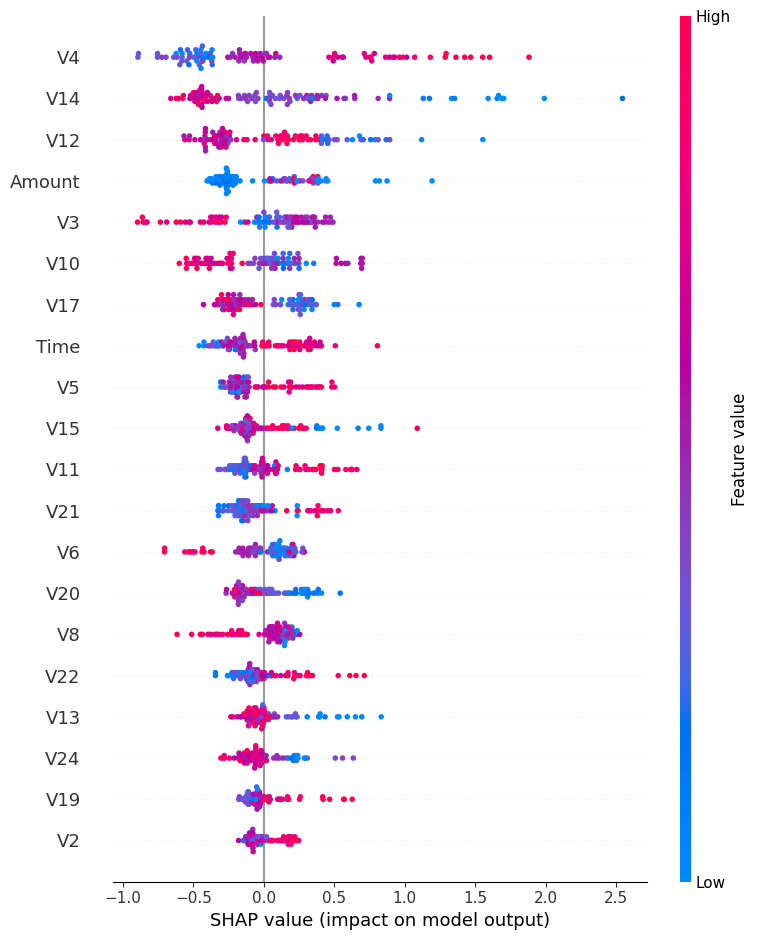

In [6]:
# ================== XGBOOST + SHAP ==================
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_proba)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train[:100])
shap.summary_plot(shap_values, pd.DataFrame(X_train[:100], columns=X.columns))

In [7]:
# ================== METRIC COMPARISON ==================
results = pd.DataFrame({
    'Model': ['Random Forest', 'CNN', 'XGBoost'],
    'Accuracy': [rf_acc, cnn_acc, xgb_acc],
    'ROC-AUC': [rf_auc, cnn_auc, xgb_auc]
})
print(results)

           Model  Accuracy   ROC-AUC
0  Random Forest  0.999434  0.961428
1            CNN  0.999279  0.956689
2        XGBoost  0.999691  0.988838


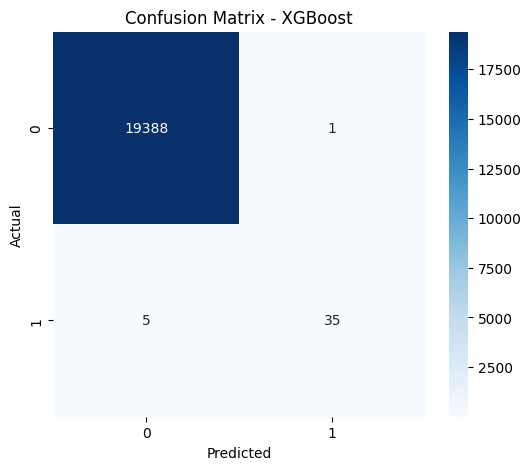

In [8]:
# ================== CONFUSION MATRIX (XGBoost) ==================
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

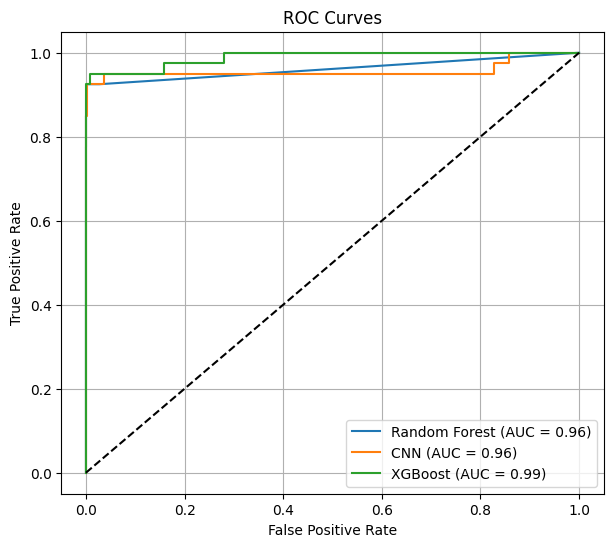

In [9]:
# ================== ROC CURVES ==================
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC = {cnn_auc:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x500 with 0 Axes>

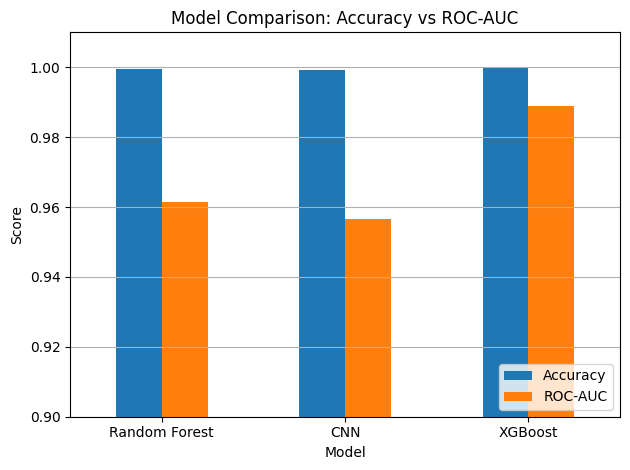

In [12]:
# ================== BAR GRAPH FOR METRIC COMPARISON ==================
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
results.set_index('Model')[['Accuracy', 'ROC-AUC']].plot(kind='bar', rot=0)
plt.title("Model Comparison: Accuracy vs ROC-AUC")
plt.ylabel("Score")
plt.ylim(0.9, 1.01)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
